# Feature Engineering

In this notebook, we will perform feature engineering on the data to be ready for the modelling.

In [1]:
# Libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.special import boxcox, inv_boxcox


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

# Configuration
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('../data/processed/rent_Valencia.csv', index_col=0)
df.head()

,price,numPhotos,floor,rooms,bathrooms,size,parkingSpacePrice,exterior,renew,new_development,hasParkingSpace,isParkingSpaceIncludedInPrice,isFinished,hasLift,hasPlan,has360,has3DTour,hasVideo,propertyType,cluster
propertyCode,,,,,,,,,,,,,,,,,,,,
97942302,850.0,23,0,5,2,140.0,0.0,False,False,False,False,False,True,False,False,False,False,False,countryHouse,3
97956954,900.0,18,1,3,3,100.0,0.0,True,False,False,True,True,True,True,False,False,False,False,duplex,0
98200619,1200.0,26,2,3,2,145.0,0.0,True,False,False,False,False,True,True,False,False,False,False,flat,0
98015046,1800.0,21,0,3,2,103.0,0.0,True,False,False,False,False,True,True,False,False,False,True,flat,0
97530419,850.0,27,5,3,1,76.0,0.0,False,False,False,False,False,True,True,False,False,False,True,flat,0


Let's start seeing the important features of the data related to the rent.

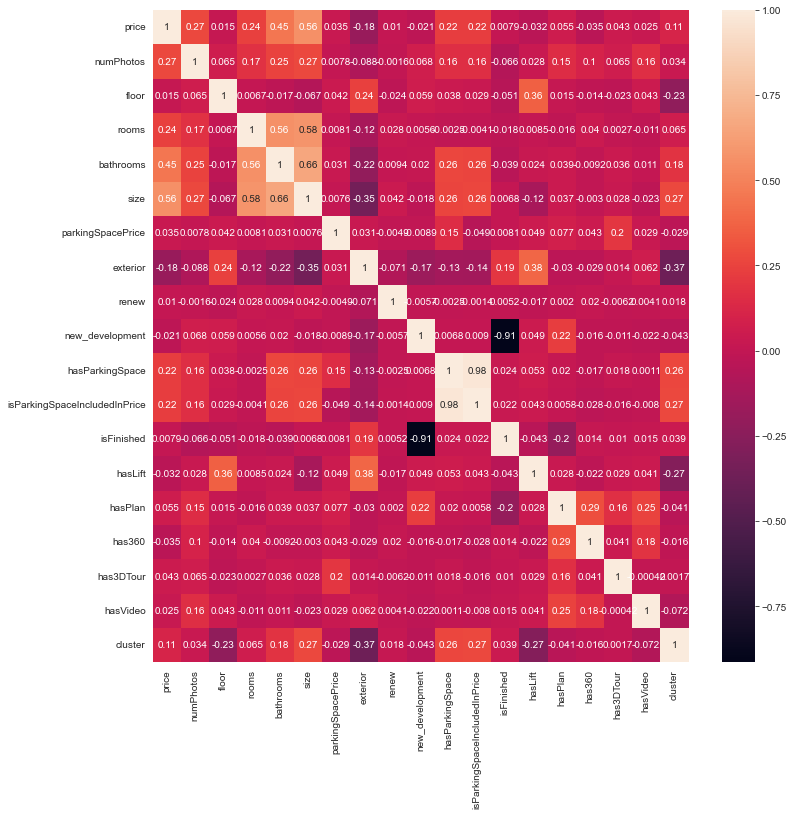

In [2]:
# Plot the correlation matrix
plt.figure(figsize=(12, 12))
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.show()

In [3]:
# Dataframe with the correlations of target variable
corr = pd.DataFrame(np.abs(df.corr()['price']).sort_values(ascending=True))
corr[corr['price'] < 0.2]

,price
isFinished,0.007942
renew,0.010102
floor,0.014618
new_development,0.020828
hasVideo,0.024653
hasLift,0.031953
parkingSpacePrice,0.034649
has360,0.035366
has3DTour,0.043027
hasPlan,0.054846


All these features are numeric, but more likely to be categorical. So this is pointless to analyze it in that way. Let's better see the importance of these features in a Random Forest model.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4168 entries, 97942302 to 97996918
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   price                          4168 non-null   float64
 1   numPhotos                      4168 non-null   int64  
 2   floor                          4168 non-null   int64  
 3   rooms                          4168 non-null   int64  
 4   bathrooms                      4168 non-null   int64  
 5   size                           4168 non-null   float64
 6   parkingSpacePrice              4168 non-null   float64
 7   exterior                       4168 non-null   bool   
 8   renew                          4168 non-null   bool   
 9   new_development                4168 non-null   bool   
 10  hasParkingSpace                4168 non-null   bool   
 11  isParkingSpaceIncludedInPrice  4168 non-null   bool   
 12  isFinished                     4168 n

In [5]:
# Make a dummy variable for the categorical variable to be used in the model
df_dummies = pd.get_dummies(df, columns=['propertyType'])

X = df_dummies.drop(['price'], axis=1)
y = df_dummies['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

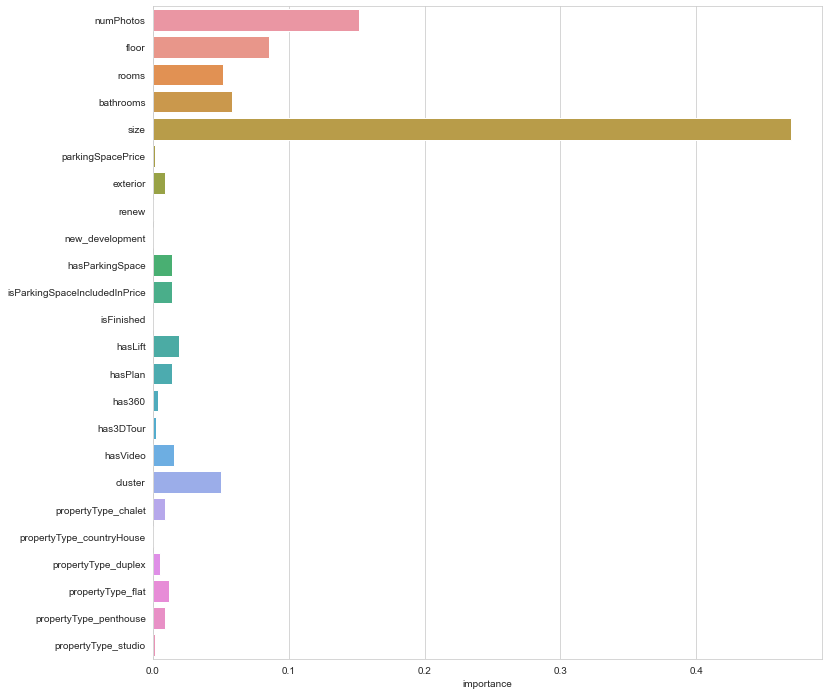

In [6]:
# Feature importance with Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

importance = rfr.feature_importances_
importance = pd.DataFrame(importance, index=X.columns, columns=['importance'])
importance.sort_values(by='importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 12))
sns.barplot(y=importance.index, x=importance.importance)
plt.show()

In [7]:
importance.sort_values(by='importance', ascending=True).head(10)

,importance
isFinished,0.000155
new_development,0.000305
propertyType_countryHouse,0.000760
renew,0.001208
propertyType_studio,0.001389
parkingSpacePrice,0.001536
has3DTour,0.001992
has360,0.003840
propertyType_duplex,0.004989
propertyType_penthouse,0.008768


IsFinished, renew and new development seems to be not very important features. To be secure let's do a statistical function to see if they are important.

In [8]:
# Feature selection with SelectKBest
selector = SelectKBest(k='all')
selector.fit(X_train, y_train)

X_train_kbest = selector.transform(X_train)
X_test_kbest = selector.transform(X_test)

# Dataframe with the scores of the features
df_kbest = pd.DataFrame({
    'column': X.columns, 
    'score': selector.scores_, 
    'p_value': (selector.pvalues_).round(3)
    }).sort_values(by='p_value', ascending=False)

df_kbest.head(10)

,column,score,p_value
7,renew,0.401725,1.000
19,propertyType_countryHouse,0.907801,0.818
16,hasVideo,1.274599,0.006
0,numPhotos,2.996757,0.000
13,hasPlan,3.068444,0.000
22,propertyType_penthouse,1.409012,0.000
21,propertyType_flat,2.545301,0.000
20,propertyType_duplex,2.925072,0.000
18,propertyType_chalet,3.788351,0.000
17,cluster,4.051114,0.000


The only drop-secure feature is renew. Because it seems that do not have anything to do with the rent. 

Before we see that our rent is slightly not normally distributed, before doing the transformation, let's see the distribution of the predicted error.

The error is not normally distributed
The error skew: -1.6181126579753462 and error kurtosis: 4.908079257563092


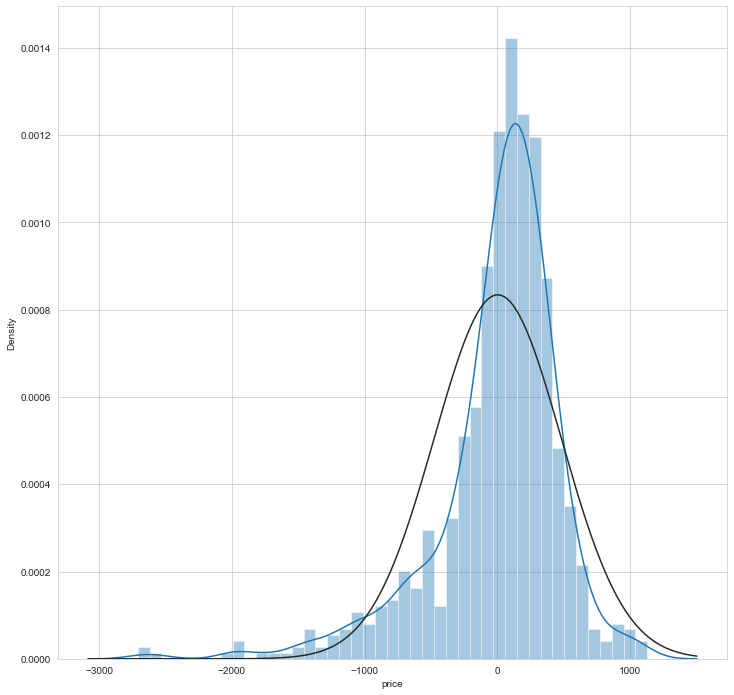

In [9]:
# Function to see if a feature is normally distributed
def is_normal(column):
    k2, p = stats.normaltest(column)
    if p < 0.05:
        return False
    else:
        return True

# Linear regression
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
error = y_pred - y_test

# Is the error normally distributed?
if is_normal(error):
    print('The error is normally distributed')
else:
    print('The error is not normally distributed')
    
print(f"The error skew: {error.skew()} and error kurtosis: {error.kurtosis()}")

# Plot the error distribution
plt.figure(figsize=(12, 12))
sns.distplot(error, fit=stats.norm)
plt.show()

So we can see that the error is not normally distributed, so we will do a transformation to make it normal variables to have better results.

Let's start with our target variable.

The error is not normally distributed
The error skew: -0.5882935168212778 and error kurtosis: 1.2036215378237185


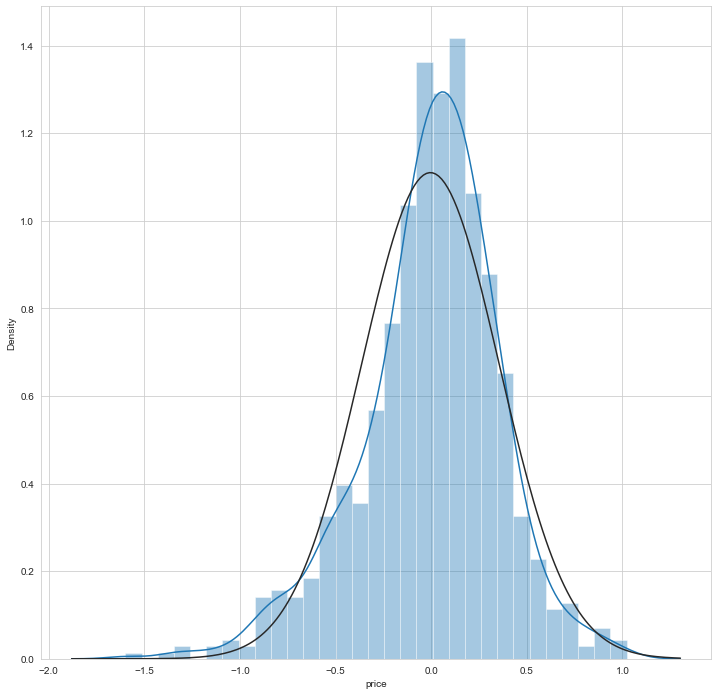

In [10]:
# Function to logarithmically transform a column
def log_transform(column):
    return np.log(column)

# Transform y_train and y_test
y_train_log = log_transform(y_train)
y_test_log = log_transform(y_test)

# Linear regression
lr = LinearRegression().fit(X_train, y_train_log)
y_pred_log = lr.predict(X_test)
error_log = y_pred_log - y_test_log

# Is the error normally distributed?
if is_normal(error_log):
    print('The error is normally distributed')
else:
    print('The error is not normally distributed')
    
print(f"The error skew: {error_log.skew()} and error kurtosis: {error_log.kurtosis()}")

# Plot the error distribution
plt.figure(figsize=(12, 12))
sns.distplot(error_log, fit=stats.norm)
plt.show()

The error is not normally distributed
The error skew: -0.16130939782668796 and error kurtosis: 0.9281728825629862


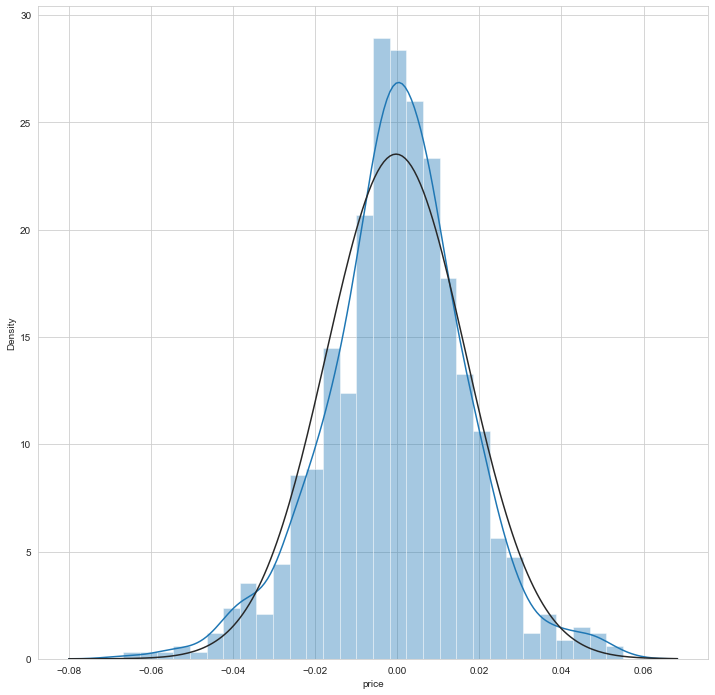

In [11]:
# Function to Box-Cox transform a column
def box_cox_transform(column, lamda= None):
    if lamda is None:
        column, lamda = stats.boxcox(column)
        
        return column, lamda
    else:
        column = boxcox(column, lamda)
        return column

def inv_box_cox_transform(column, lamda):
    column = inv_boxcox(column, lamda)
    return column
    
# Transform y_train and y_test
y_train_box, lamda = box_cox_transform(y_train)
y_test_box = box_cox_transform(y_test, lamda)

# Linear regression
lr = LinearRegression().fit(X_train, y_train_box)
y_pred_box = lr.predict(X_test)
error_box = y_pred_box - y_test_box

# Is the error normally distributed?
if is_normal(error_box):
    print('The error is normally distributed')
else:
    print('The error is not normally distributed')
    
print(f"The error skew: {error_box.skew()} and error kurtosis: {error_box.kurtosis()}")

# Plot the error distribution
plt.figure(figsize=(12, 12))
sns.distplot(error_box, fit=stats.norm)
plt.show()

So it is not sufficient to just transform our target variable, so we need to do more drastic transformations.

Let's transform our X variables too, to see if we can use the linear regression model

The error is not normally distributed
The error skew: -0.24098718559307344 and error kurtosis: 0.8974908157543564


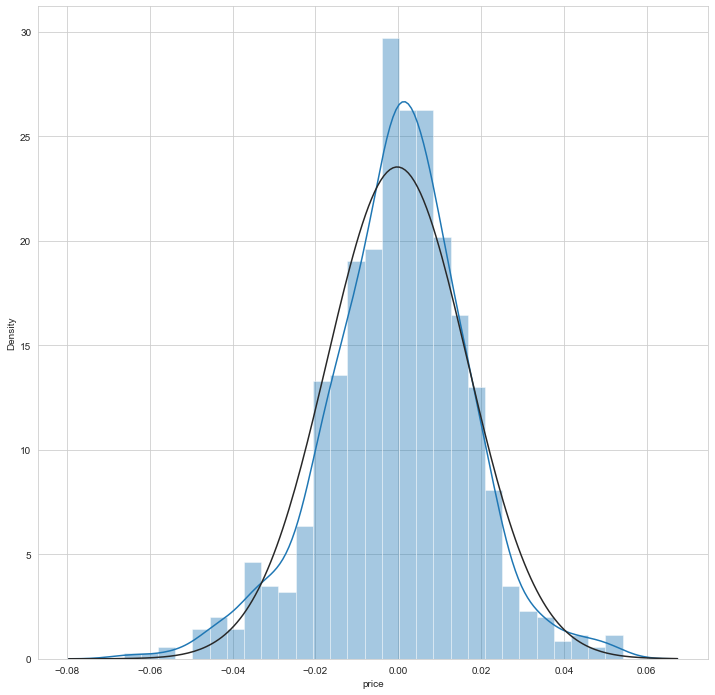

In [12]:
pt = PowerTransformer()
X_train_pt = pt.fit_transform(X_train)
X_test_pt = pt.transform(X_test)

# Linear regression 
lr = LinearRegression().fit(X_train_pt, y_train_box) # y_train_box is the transformed y_train
y_pred_box_pt = lr.predict(X_test_pt)
error_box_pt = y_pred_box_pt - y_test_box

# Is the error normally distributed?
if is_normal(error_box_pt):
    print('The error is normally distributed')
else:
    print('The error is not normally distributed')

print(f"The error skew: {error_box_pt.skew()} and error kurtosis: {error_box_pt.kurtosis()}")

# Plot the error distribution
plt.figure(figsize=(12, 12))
sns.distplot(error_box_pt, fit=stats.norm)
plt.show()

So there is not really a need to transform the X variables, maybe it is because our numerical variables are not really continuous numerical variables, they are discrete numerical variables.

Our third way to try to obtain a normally distributed error is use bootstraping. But before that let see if there exist any colineality between the variables because this is turning to be a serious problem.

In [13]:
# Is there exists coliniarity or multicolinarity between the features?
def calculate_vif(df, features):
    vif, tolerance = {}, {}

    # all the features are used to calculate the VIF
    for col in features:
        # extract all the other except the current feature
        X = [f for f in features if f != col]
        X, y = df[X], df[col]

        # extract the R-squared value for the current feature
        r2 = LinearRegression().fit(X, y).score(X, y)

        # calculate the tolerance
        tolerance[col] = 1 - r2

        # calculate the VIF
        vif[col] = 1 / (tolerance[col])

    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance}).sort_values(by='VIF', ascending=False)

numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

calculate_vif(df, numerical_features)

,VIF,Tolerance
size,2.612785,0.382733
bathrooms,2.022328,0.494480
rooms,1.723222,0.580308
price,1.569739,0.637048
cluster,1.154036,0.866524
numPhotos,1.119819,0.893001
floor,1.064880,0.939073
parkingSpacePrice,1.004443,0.995576


So between the numerical variables, seems that there is no colineality.. Let's see if our categorical variables are independent or not.

In [14]:
# Function that create a contingency table between two columns
def contingency_table(column1, column2):
    table = pd.crosstab(column1, column2)
    return table

# Function that calculate the chi-square test between two columns
def chi_square_test(column1, column2):
    table = contingency_table(column1, column2)
    chi2, p, dof, expected = stats.chi2_contingency(table)
    return chi2, p

categorical_features = df.select_dtypes(include=['object', 'bool']).columns

# Make a dataframe with the chi-square test between categorical features
f1, f2, chi2, p = [], [], [], []

for col in categorical_features:
    for col2 in categorical_features:
        if col != col2:
            chi2_, p_ = chi_square_test(df[col], df[col2])
            f1.append(col)
            f2.append(col2)
            chi2.append(chi2_)
            p.append(p_)

chi_square_df = pd.DataFrame({'Column 1': f1, 'Column 2': f2, 'Chi-square': chi2, 'P-value': p})
chi_square_df[chi_square_df['P-value'] < 0.05]

,Column 1,Column 2,Chi-square,P-value
0,exterior,renew,17.215870,3.336376e-05
1,exterior,new_development,117.559732,2.164814e-27
2,exterior,hasParkingSpace,69.230849,8.758731e-17
3,exterior,isParkingSpaceIncludedInPrice,77.675258,1.214533e-18
4,exterior,isFinished,150.756288,1.184830e-34
5,exterior,hasLift,605.715413,9.564473e-134
9,exterior,hasVideo,15.701745,7.415573e-05
10,exterior,propertyType,2330.252543,0.000000e+00
11,renew,exterior,17.215870,3.336376e-05
21,renew,propertyType,28.216824,3.301302e-05


So this could be our problem... It seems that our categorical variables are not independent between each other so let's try if drop some features if we have a better model.

We will work with Box-Cox transformation on our dependent variable, and drop 'renew' first, and there let's see if we can get a better model.

In [16]:
X = df_dummies.drop(['price', 'renew'], axis=1)
y = df_dummies['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Box-Cox transform the y_train and y_test (To normalize the data)
y_train, lamda = box_cox_transform(y_train)
y_test = box_cox_transform(y_test, lamda)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Select best features
selector = SelectKBest(f_regression, k='all') 
selector.fit(X_train, y_train)

# Get the columns that are selected
selected_features = selector.get_support(indices=True)
scores = selector.scores_
features = X.columns
p_values = selector.pvalues_
scores_df = pd.DataFrame({'Features': features, 'Scores': scores, 'p_value': p_values})

scores_df = scores_df.sort_values(by='Scores', ascending=False)
scores_df

,Features,Scores,p_value
4,size,1049.731401,1.972975e-200
3,bathrooms,777.988924,4.671162e-154
0,numPhotos,307.471884,6.491824e-66
2,rooms,255.479142,1.819669e-55
17,propertyType_chalet,228.162434,6.502716e-50
20,propertyType_flat,133.983797,2.085849e-30
8,hasParkingSpace,114.453646,2.755774e-26
9,isParkingSpaceIncludedInPrice,106.629263,1.257034e-24
6,exterior,62.730654,3.201887e-15
22,propertyType_studio,27.708245,1.499882e-07


So the cluster in numeric variable it not really working so let transform it into a categorical variable.

The legend could be:
* 0 is for central
* 1 is for south
* 2 is for north
* 3 is for west

In [17]:
# Transform cluster column
df['cluster'] = df['cluster'].map({0: 'central', 1: 'south', 2: 'north', 3: 'west'})

# Let's make dummy variables for the cluster and propertyType columns
df_dummies = pd.get_dummies(df, columns=['cluster', 'propertyType'])
df_dummies

,price,numPhotos,floor,rooms,bathrooms,size,parkingSpacePrice,exterior,renew,new_development,hasParkingSpace,isParkingSpaceIncludedInPrice,isFinished,hasLift,hasPlan,has360,has3DTour,hasVideo,cluster_central,cluster_north,cluster_south,cluster_west,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio
propertyCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,
97942302,850.0,23,0,5,2,140.0,0.0,False,False,False,False,False,True,False,False,False,False,False,0,0,0,1,0,1,0,0,0,0
97956954,900.0,18,1,3,3,100.0,0.0,True,False,False,True,True,True,True,False,False,False,False,1,0,0,0,0,0,1,0,0,0
98200619,1200.0,26,2,3,2,145.0,0.0,True,False,False,False,False,True,True,False,False,False,False,1,0,0,0,0,0,0,1,0,0
98015046,1800.0,21,0,3,2,103.0,0.0,True,False,False,False,False,True,True,False,False,False,True,1,0,0,0,0,0,0,1,0,0
97530419,850.0,27,5,3,1,76.0,0.0,False,False,False,False,False,True,True,False,False,False,True,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97433173,625.0,6,1,1,1,60.0,0.0,True,False,False,False,False,True,True,False,False,False,False,1,0,0,0,0,0,0,1,0,0
97428394,600.0,4,2,0,1,78.0,0.0,True,False,False,False,False,True,True,False,False,False,False,1,0,0,0,0,0,0,0,0,1
94396615,600.0,9,4,1,1,45.0,0.0,True,False,False,False,False,True,True,False,False,False,False,1,0,0,0,0,0,0,1,0,0


In [19]:
X = df_dummies.drop(['price'], axis=1)
y = df_dummies['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Box-Cox transform the y_train and y_test (To normalize the data)
y_train, lamda = box_cox_transform(y_train)
y_test = box_cox_transform(y_test, lamda)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Select best features
selector = SelectKBest(f_regression, k='all') 
selector.fit(X_train, y_train)

# Get the columns that are selected
selected_features = selector.get_support(indices=True)
scores = selector.scores_
features = X.columns
p_values = selector.pvalues_
scores_df = pd.DataFrame({'Features': features, 'Scores': scores, 'p_value': p_values})

scores_df = scores_df.sort_values(by='Scores', ascending=False)
scores_df

,Features,Scores,p_value
4,size,1049.731401,1.972975e-200
3,bathrooms,777.988924,4.671162e-154
0,numPhotos,307.471884,6.491824e-66
2,rooms,255.479142,1.819669e-55
21,propertyType_chalet,228.162434,6.502716e-50
24,propertyType_flat,133.983797,2.085849e-30
9,hasParkingSpace,114.453646,2.755774e-26
10,isParkingSpaceIncludedInPrice,106.629263,1.257034e-24
6,exterior,62.730654,3.201887e-15
19,cluster_south,49.301861,2.648113e-12


Let's see the importance in a Random Forest model.

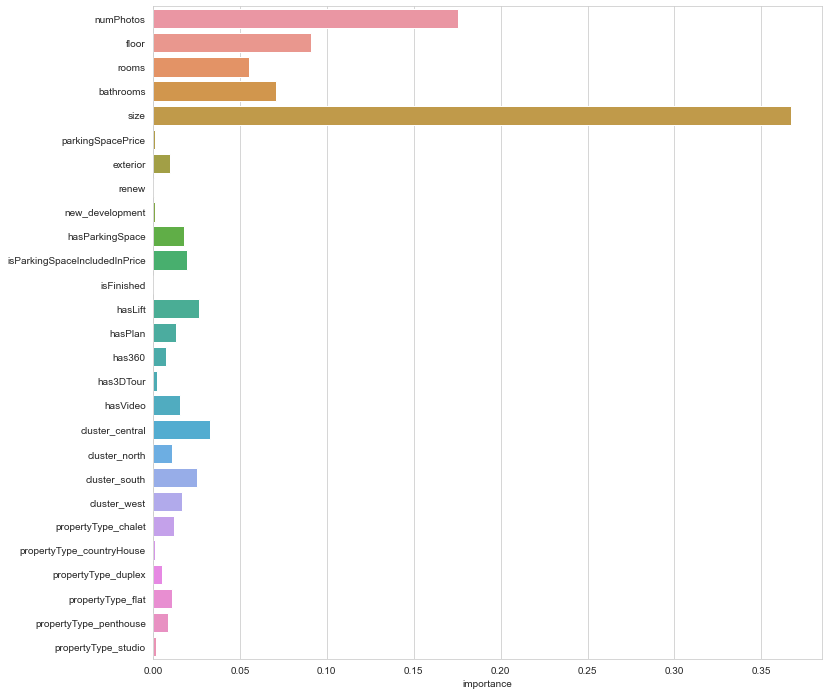

In [20]:
# Feature importance with Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

importance = rfr.feature_importances_
importance = pd.DataFrame(importance, index=X.columns, columns=['importance'])
importance.sort_values(by='importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 12))
sns.barplot(y=importance.index, x=importance.importance)
plt.show()

The error is not normally distributed
The error skew: 0.35706356595741734 and error kurtosis: 1.9260315963553443


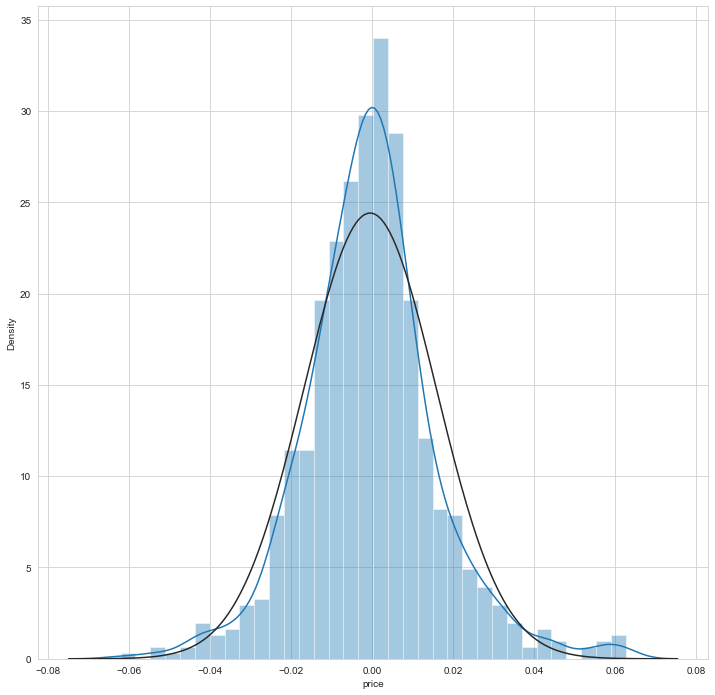

In [21]:
y_pred = rfr.predict(X_test)
error = y_test - y_pred

# Is the error normally distributed?
if is_normal(error):
    print('The error is normally distributed')
else:
    print('The error is not normally distributed')
    
print(f"The error skew: {error.skew()} and error kurtosis: {error.kurtosis()}")

# Plot the error distribution
plt.figure(figsize=(12, 12))
sns.distplot(error, fit=stats.norm)
plt.show()

### Conclusion
* In the preprocess data preparation to the model, we need to Box-Cox transformation on the dependent variable, because it will better fit the data into the model.
* In next notebooks we will have an eye on features because it seems like some are redudant.
* We need to transform the cluster data into a categorical variable to be useful in the modelling.
* The Linear Regression model is not working well, so we will try another model of regression, there no seems to be any linear relationship between the features and the target variable or the features are too non-Normal distributed so it will not fulfill the requirements of the linear model. The ensemble model seems to be better in this case.